In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount("/content/drive")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path = "drive/MyDrive/PyTorch/Data/NYCTaxiFares.csv"
df = pd.read_csv(path)
print(f"Shape : ", df.shape)

Shape :  (120000, 8)


In [3]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [4]:
df[["fare_amount"]].describe().T

,count,mean,std,min,25%,50%,75%,max
fare_amount,120000.0,10.040326,7.500134,2.5,5.7,7.7,11.3,49.9


## Calculate the distance traveled
The <a href='https://en.wikipedia.org/wiki/Haversine_formula'>haversine formula</a> calculates the distance on a sphere between two sets of GPS coordinates.<br>
Here we assign latitude values with $\varphi$ (phi) and longitude with $\lambda$ (lambda).

The distance formula works out to

${\displaystyle d=2r\arcsin \left({\sqrt {\sin ^{2}\left({\frac {\varphi _{2}-\varphi _{1}}{2}}\right)+\cos(\varphi _{1})\:\cos(\varphi _{2})\:\sin ^{2}\left({\frac {\lambda _{2}-\lambda _{1}}{2}}\right)}}\right)}$

where

$\begin{split} r&: \textrm {radius of the sphere (Earth's radius averages 6371 km)}\\
\varphi_1, \varphi_2&: \textrm {latitudes of point 1 and point 2}\\
\lambda_1, \lambda_2&: \textrm {longitudes of point 1 and point 2}\end{split}$

In [5]:
def haversine_distance(dataframe, lat1, long1, lat2, long2):

    """
        Calculates The Haversine Distance Between 2 Sets of GPS Coordinates In Dataframe
    """

    r = 6371 # average radius of Earth in kilometers

    phi1 = np.radians(dataframe[lat1])
    phi2 = np.radians(dataframe[lat2])

    delta_phi = np.radians(dataframe[lat2] - dataframe[lat1])
    delta_lambda = np.radians(dataframe[long2] - dataframe[long1])

    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r*c) # In Kilometers

    return d 

In [6]:
df["dist_km"] = haversine_distance(df, "pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


By creating a datetime object, we can extract information like "day of the week", "am vs. pm" etc. Note that the data was saved in UTC time. Our data falls in April of 2010 which occurred during Daylight Savings Time in New York. For that reason, we'll make an adjustment to EDT using UTC-4 (subtracting four hours).

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_datetime    120000 non-null  object 
 1   fare_amount        120000 non-null  float64
 2   fare_class         120000 non-null  int64  
 3   pickup_longitude   120000 non-null  float64
 4   pickup_latitude    120000 non-null  float64
 5   dropoff_longitude  120000 non-null  float64
 6   dropoff_latitude   120000 non-null  float64
 7   passenger_count    120000 non-null  int64  
 8   dist_km            120000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 8.2+ MB


In [8]:
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   pickup_datetime    120000 non-null  datetime64[ns, UTC]
 1   fare_amount        120000 non-null  float64            
 2   fare_class         120000 non-null  int64              
 3   pickup_longitude   120000 non-null  float64            
 4   pickup_latitude    120000 non-null  float64            
 5   dropoff_longitude  120000 non-null  float64            
 6   dropoff_latitude   120000 non-null  float64            
 7   passenger_count    120000 non-null  int64              
 8   dist_km            120000 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(2)
memory usage: 8.2 MB


In [9]:
pd.Timedelta(hours = 4 )

Timedelta('0 days 04:00:00')

In [10]:
df["pickup_datetime"].min(),df["pickup_datetime"].max()

(Timestamp('2010-04-11 04:00:10+0000', tz='UTC'),
 Timestamp('2010-04-25 03:59:42+0000', tz='UTC'))

In [11]:
df["EDTdate"] = df["pickup_datetime"] - pd.Timedelta(hours = 4)

In [12]:
df["EDTdate"].min(),df["EDTdate"].max()

(Timestamp('2010-04-11 00:00:10+0000', tz='UTC'),
 Timestamp('2010-04-24 23:59:42+0000', tz='UTC'))

In [13]:
df["Hour"] = df["EDTdate"].dt.hour
df["AMorPM"] = np.where(df["Hour"] < 12, "am","pm")
df["WeekDay"] = df["EDTdate"].dt.strftime("%a")

In [14]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,WeekDay
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,am,Mon
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,am,Sat
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,am,Sat
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,pm,Sun
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,pm,Fri


In [15]:
df.dtypes

pickup_datetime      datetime64[ns, UTC]
fare_amount                      float64
fare_class                         int64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dist_km                          float64
EDTdate              datetime64[ns, UTC]
Hour                               int64
AMorPM                            object
WeekDay                           object
dtype: object

In [16]:
cat_cols = ["Hour","AMorPM","WeekDay"]
cont_cols = ['pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude','passenger_count', 'dist_km']
y_col = ["fare_amount"]

In [17]:
for cat in cat_cols:
    df[cat] = df[cat].astype("category")

df.dtypes

pickup_datetime      datetime64[ns, UTC]
fare_amount                      float64
fare_class                         int64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dist_km                          float64
EDTdate              datetime64[ns, UTC]
Hour                            category
AMorPM                          category
WeekDay                         category
dtype: object

In [18]:
df["Hour"].head()

0     4
1    11
2     7
3    17
4    22
Name: Hour, dtype: category
Categories (24, int64): [0, 1, 2, 3, ..., 20, 21, 22, 23]

In [19]:
df["WeekDay"].head()

0    Mon
1    Sat
2    Sat
3    Sun
4    Fri
Name: WeekDay, dtype: category
Categories (7, object): ['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed']

In [20]:
df["AMorPM"].head()

0    am
1    am
2    am
3    pm
4    pm
Name: AMorPM, dtype: category
Categories (2, object): ['am', 'pm']

In [21]:
df["WeekDay"].cat.categories,df["AMorPM"].cat.categories,df["Hour"].cat.categories

(Index(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype='object'),
 Index(['am', 'pm'], dtype='object'),
 Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
             17, 18, 19, 20, 21, 22, 23],
            dtype='int64'))

In [22]:
# Sayısal olarak çevirdi !!!

df["WeekDay"].head().cat.codes

0    1
1    2
2    2
3    3
4    0
dtype: int8

In [23]:
hr = df["Hour"].cat.codes.values
ampm = df["AMorPM"].cat.codes.values
wkdy = df["WeekDay"].cat.codes.values

cats = np.stack([hr,ampm,wkdy],axis = 1)
cats[:5]

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       [17,  1,  3],
       [22,  1,  0]], dtype=int8)

In [24]:
cats = np.stack([df[col].cat.codes.values for col in cat_cols], axis = 1)
cats[:5]

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       [17,  1,  3],
       [22,  1,  0]], dtype=int8)

In [25]:
cats = torch.tensor(cats, dtype = torch.int64)
cats[:5]

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3],
        [22,  1,  0]])

In [26]:
conts = np.stack([df[col].values for col in cont_cols], axis = 1)
conts = torch.tensor(conts, dtype = torch.float)
conts[:5]

tensor([[-73.9924,  40.7305, -73.9755,  40.7447,   1.0000,   2.1263],
        [-73.9901,  40.7406, -73.9742,  40.7441,   1.0000,   1.3923],
        [-73.9941,  40.7511, -73.9601,  40.7662,   2.0000,   3.3268],
        [-73.9905,  40.7564, -73.9712,  40.7482,   1.0000,   1.8641],
        [-73.9910,  40.7342, -73.9060,  40.7431,   1.0000,   7.2313]])

In [27]:
type(cats),type(conts)

(torch.Tensor, torch.Tensor)

In [28]:
y = torch.tensor(df[y_col].values , dtype = torch.float).reshape(-1,1)
y[:5]

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        [ 8.9000],
        [19.7000]])

In [29]:
cats.shape,conts.shape,y.shape

(torch.Size([120000, 3]), torch.Size([120000, 6]), torch.Size([120000, 1]))

In [30]:
cat_sizes = [len(df[col].cat.categories) for col in cat_cols]
emb_sizes = [ (size, min(50 , (size + 1) // 2)) for size in cat_sizes]
emb_sizes

[(24, 12), (2, 1), (7, 4)]

In [31]:
# Normalde bu categoric ve 3 features sahib ama biz bu kategorik değişkenleri hepsi için ayrı bir sütuna çevirseydik
# Features sayımız çok fazla olabilicekti
# Biz bunu çeviriyoruz yani 24 tane kategorik değişkeni olan değeri 12 kategorik çeviriyoruz aslında !!!

# One Hot Encoder gibi yani ordan çağırıştır !!!

catz = cats[:2]
catz

tensor([[ 4,  0,  1],
        [11,  0,  2]])

In [32]:
selfembeds = nn.ModuleList([nn.Embedding(ni , nf) for ni, nf in emb_sizes])
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [33]:
list(enumerate(selfembeds))

[(0, Embedding(24, 12)), (1, Embedding(2, 1)), (2, Embedding(7, 4))]

In [34]:
emb_sizes

[(24, 12), (2, 1), (7, 4)]

In [35]:
# Her bir cat cols için bir min değeri ayarladık yani 
# ilk sütun için 24 eşsiz değere karşılık onu temsil eden 12 boyutlu bir vektor oluşturduk !!!
# ikinci için 1 boyutlu
# üçüncü için 4 boyutlu 
# Bunlar birer örnek !!!

embeddingz = []
for i,e in enumerate(selfembeds):
    embeddingz.append(e(catz[:,i]))

embeddingz

[tensor([[-1.8186, -0.6188, -0.2390,  1.7699, -1.1341, -0.2494, -0.5799, -0.4951,
          -0.4249, -0.0629, -0.8381,  1.2792],
         [-1.7097,  0.0306, -1.1876,  1.8943,  0.7349, -0.6297, -1.0138, -0.9481,
           1.3919,  2.4371, -1.2899, -0.0825]], grad_fn=<EmbeddingBackward0>),
 tensor([[-0.8317],
         [-0.8317]], grad_fn=<EmbeddingBackward0>),
 tensor([[ 0.0195, -0.3260,  0.1286,  1.0332],
         [ 0.7686,  2.2123, -0.8129, -0.6198]], grad_fn=<EmbeddingBackward0>)]

In [36]:
embeddingz[0]

tensor([[-1.8186, -0.6188, -0.2390,  1.7699, -1.1341, -0.2494, -0.5799, -0.4951,
         -0.4249, -0.0629, -0.8381,  1.2792],
        [-1.7097,  0.0306, -1.1876,  1.8943,  0.7349, -0.6297, -1.0138, -0.9481,
          1.3919,  2.4371, -1.2899, -0.0825]], grad_fn=<EmbeddingBackward0>)

In [37]:
embeddingz[1]

tensor([[-0.8317],
        [-0.8317]], grad_fn=<EmbeddingBackward0>)

In [38]:
embeddingz[2]

tensor([[ 0.0195, -0.3260,  0.1286,  1.0332],
        [ 0.7686,  2.2123, -0.8129, -0.6198]], grad_fn=<EmbeddingBackward0>)

In [39]:
# Burda oluşturulan 1,2 ve 3. için çıkan vektörleri vertical göre sıraladık !!!

z = torch.cat(embeddingz, dim = 1)
z

tensor([[-1.8186, -0.6188, -0.2390,  1.7699, -1.1341, -0.2494, -0.5799, -0.4951,
         -0.4249, -0.0629, -0.8381,  1.2792, -0.8317,  0.0195, -0.3260,  0.1286,
          1.0332],
        [-1.7097,  0.0306, -1.1876,  1.8943,  0.7349, -0.6297, -1.0138, -0.9481,
          1.3919,  2.4371, -1.2899, -0.0825, -0.8317,  0.7686,  2.2123, -0.8129,
         -0.6198]], grad_fn=<CatBackward0>)

In [40]:
z.shape

torch.Size([2, 17])

In [41]:
selfembdrop = nn.Dropout(0.4)
selfembdrop

Dropout(p=0.4, inplace=False)

In [42]:
z = selfembdrop(z)
z

tensor([[-0.0000, -0.0000, -0.3984,  0.0000, -1.8901, -0.4157, -0.9664, -0.8251,
         -0.0000, -0.1048, -0.0000,  2.1319, -1.3861,  0.0000, -0.0000,  0.0000,
          1.7220],
        [-2.8495,  0.0511, -1.9793,  3.1572,  1.2248, -0.0000, -0.0000, -0.0000,
          0.0000,  4.0619, -2.1498, -0.1376, -1.3861,  1.2810,  3.6871, -0.0000,
         -1.0330]], grad_fn=<MulBackward0>)

In [43]:
torch.cat([z, conts[:2]] , dim = 1).shape

torch.Size([2, 23])

----

In [44]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz , layers , p = 0.5):

        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni ,nf) for ni, nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)

        layerlist =[]
        n_emb = sum((nf for ni, nf in emb_szs))
        n_in = n_emb + n_cont

        for i in layers:
            layerlist.append(nn.Linear(n_in, i))
            layerlist.append(nn.ReLU(inplace = True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i

        layerlist.append(nn.Linear(layers[-1], out_sz))

        self.layers = nn.Sequential(*layerlist)


    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))

        x = torch.cat(embeddings, dim = 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], dim = 1)
        x = self.layers(x)
        return x

In [45]:
emb_sizes,conts.shape

([(24, 12), (2, 1), (7, 4)], torch.Size([120000, 6]))

In [46]:
torch.manual_seed(33)
model = TabularModel(emb_sizes, conts.shape[1], 1, [200,100], p = 0.4)
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [47]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [48]:
batch_size = 60000
test_size = int(batch_size*0.2)

batch_size,test_size,batch_size - test_size

(60000, 12000, 48000)

In [49]:
cats.shape,conts.shape,y.shape

(torch.Size([120000, 3]), torch.Size([120000, 6]), torch.Size([120000, 1]))

In [50]:
cat_train = cats[:batch_size - test_size]
cat_test = cats[batch_size - test_size:batch_size]

con_train = conts[:batch_size - test_size]
con_test = conts[batch_size - test_size:batch_size]

y_train = y[:batch_size - test_size]
y_test = y[batch_size - test_size : batch_size]

len(cat_train),len(con_train),len(y_train)

(48000, 48000, 48000)

In [51]:
cat_train.shape, con_train.shape, y_train.shape

(torch.Size([48000, 3]), torch.Size([48000, 6]), torch.Size([48000, 1]))

In [52]:
cat_test.shape, con_test.shape, y_test.shape

(torch.Size([12000, 3]), torch.Size([12000, 6]), torch.Size([12000, 1]))

In [53]:
torch.cat([z, con_train[:2]] ,dim = 1).shape

torch.Size([2, 23])

In [54]:
import time
start_time = time.time()

epochs = 300

losses = []

for i in range(epochs):

    i +=1
    y_pred = model(cat_train,con_train)
    loss = torch.sqrt(criterion(y_pred , y_train)) # RMSE
    losses.append(loss)

    if i % 25 == 1:
        print(f"Epoch : {i:3}, Loss : {loss:.4f}")

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

duration = time.time() - start_time
print()
print(f"Epochs : {i:3}, Last Loss : {loss:.4f}")
print(f"Traning Took {duration / 60} minutes")

Epoch :   1, Loss : 12.5861
Epoch :  26, Loss : 10.9045
Epoch :  51, Loss : 10.2353
Epoch :  76, Loss : 9.7415
Epoch : 101, Loss : 9.1740
Epoch : 126, Loss : 8.3997
Epoch : 151, Loss : 7.3638
Epoch : 176, Loss : 6.2051
Epoch : 201, Loss : 5.0160
Epoch : 226, Loss : 4.2286
Epoch : 251, Loss : 3.8929
Epoch : 276, Loss : 3.7627

Epochs : 300, Last Loss : 3.7149
Traning Took 2.1227187077204386 minutes


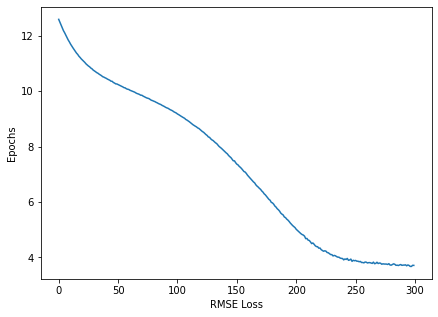

In [55]:
plt.figure(figsize = (7,5))
plt.plot(range(epochs), losses)
plt.xlabel("RMSE Loss")
plt.ylabel("Epochs")
plt.show()

In [56]:
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = torch.sqrt(criterion(y_val, y_test))

print(f"RMSE : {loss:.8f}")

RMSE : 3.64779067


In [57]:
print(f'{"PREDICTED":>12}   {"ACTUAL":>8}  {"DIFF":>8}')

for i in range(50):
    diff = np.abs(y_val[i].item() - y_test[i].item())
    print(f"{i+1:3}.) Y Val : {y_val[i].item():8.2f} , Y Test : {y_test[i].item():8.2f} , Diff :{diff:8.2f}")

   PREDICTED     ACTUAL      DIFF
  1.) Y Val :     4.81 , Y Test :     2.90 , Diff :    1.91
  2.) Y Val :    13.71 , Y Test :     5.70 , Diff :    8.01
  3.) Y Val :     7.37 , Y Test :     7.70 , Diff :    0.33
  4.) Y Val :    13.61 , Y Test :    12.50 , Diff :    1.11
  5.) Y Val :     6.99 , Y Test :     4.10 , Diff :    2.89
  6.) Y Val :     5.90 , Y Test :     5.30 , Diff :    0.60
  7.) Y Val :     1.55 , Y Test :     3.70 , Diff :    2.15
  8.) Y Val :    19.14 , Y Test :    14.50 , Diff :    4.64
  9.) Y Val :     4.89 , Y Test :     5.70 , Diff :    0.81
 10.) Y Val :    14.05 , Y Test :    10.10 , Diff :    3.95
 11.) Y Val :     7.55 , Y Test :     4.50 , Diff :    3.05
 12.) Y Val :     2.79 , Y Test :     6.10 , Diff :    3.31
 13.) Y Val :     4.44 , Y Test :     6.90 , Diff :    2.46
 14.) Y Val :     9.33 , Y Test :    14.10 , Diff :    4.77
 15.) Y Val :     5.87 , Y Test :     4.50 , Diff :    1.37
 16.) Y Val :    28.38 , Y Test :    34.10 , Diff :    5.72
 17.) 

In [58]:
if len(losses) == epochs:

    torch.save(model.state_dict(), "TaxiFareRegrModel.pt")

else:

    print('Model has not been trained. Consider loading a trained model instead.')

----

In [59]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

def haversine_distance(df, lat1, long1, lat2, long2):
    r = 6371
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return r * c
    
class TabularModel(nn.Module):
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        self.layers = nn.Sequential(*layerlist)
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        return self.layers(x)

In [60]:
emb_szs = [(24, 12), (2, 1), (7, 4)]
model2 = TabularModel(emb_szs, 6, 1, [200,100], p=0.4)

In [61]:
model2.load_state_dict(torch.load("TaxiFareRegrModel.pt"))
model2.eval()

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [62]:
def test_data(mdl):

    # INPUT NEW DATA

    #plat = float(input('What is the pickup latitude?  '))
    #plong = float(input('What is the pickup longitude? '))
    #dlat = float(input('What is the dropoff latitude?  '))
    #dlong = float(input('What is the dropoff longitude? '))
    #psngr = int(input('How many passengers? '))
    #dt = input('What is the pickup date and time?\nFormat as YYYY-MM-DD HH:MM:SS     ')

    plat = 40.5
    plong = -73.9
    dlat = 40.52
    dlong = -73.92
    psngr = 2
    dt = "2010-04-15 16:00:00"

    # PREPROCESS THE DATA
    dfx_dict = {'pickup_latitude':plat,'pickup_longitude':plong,'dropoff_latitude':dlat,
         'dropoff_longitude':dlong,'passenger_count':psngr,'EDTdate':dt}
    dfx = pd.DataFrame(dfx_dict, index=[0])
    dfx['dist_km'] = haversine_distance(dfx,'pickup_latitude', 'pickup_longitude',
                                        'dropoff_latitude', 'dropoff_longitude')
    dfx['EDTdate'] = pd.to_datetime(dfx['EDTdate'])
    
    # We can skip the .astype(category) step since our fields are small,
    # and encode them right away
    dfx['Hour'] = dfx['EDTdate'].dt.hour
    dfx['AMorPM'] = np.where(dfx['Hour']<12,0,1) 
    dfx['WeekDay'] = dfx['EDTdate'].dt.strftime("%a")
    dfx['WeekDay'] = dfx['WeekDay'].replace(['Fri','Mon','Sat','Sun','Thu','Tue','Wed'],
                                            [0,1,2,3,4,5,6]).astype('int64')
    # CREATE CAT AND CONT TENSORS
    cat_cols = ['Hour', 'AMorPM', 'WeekDay']
    cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
                 'dropoff_longitude', 'passenger_count', 'dist_km']
                 
    xcats = np.stack([dfx[col].values for col in cat_cols], 1)
    xcats = torch.tensor(xcats, dtype=torch.int64)

    xconts = np.stack([dfx[col].values for col in cont_cols], 1)
    xconts = torch.tensor(xconts, dtype=torch.float)
    
    # PASS NEW DATA THROUGH THE MODEL WITHOUT PERFORMING A BACKPROP
    with torch.no_grad():
        z = mdl(xcats, xconts)
    print(f'\nThe predicted fare amount is ${z.item():.2f}')

In [63]:
# 2010-04-15 16:00:00
test_data(model2)


The predicted fare amount is $3610.26


----

# ANNs Classification 

In [64]:
y_col = ["fare_class"]
y = torch.tensor(df[y_col].values).flatten()
y.shape,type(y)


(torch.Size([120000]), torch.Tensor)

In [65]:
pd.Series(y).unique()

array([0, 1])

In [66]:
pd.Series(y).value_counts()

0    80000
1    40000
dtype: int64

In [67]:
emb_sizes

[(24, 12), (2, 1), (7, 4)]

In [68]:
torch.manual_seed(33)
model = TabularModel(emb_sizes, conts.shape[1], 2, [200,100], p = 0.4)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [69]:
batch_size = 60000
test_size = 12000

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]

con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]

y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [70]:
import time

start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):

    i+=1
    y_pred = model(cat_train, con_train) 
    loss = criterion(y_pred,y_train)
    losses.append(loss)

    if i % 25 == 1:
        print(f"Epoch : {i:3}, Loss : {loss.item():.4f}")

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print()
print(f'Epoch: {i:3},  Loss: {loss.item():.4f}') 
print(f'\nDuration: {time.time() - start_time:.0f} seconds') 

Epoch :   1, Loss : 0.8242
Epoch :  26, Loss : 0.3746
Epoch :  51, Loss : 0.3369
Epoch :  76, Loss : 0.3124
Epoch : 101, Loss : 0.3019
Epoch : 126, Loss : 0.2923
Epoch : 151, Loss : 0.2843
Epoch : 176, Loss : 0.2820
Epoch : 201, Loss : 0.2745
Epoch : 226, Loss : 0.2698
Epoch : 251, Loss : 0.2644
Epoch : 276, Loss : 0.2630

Epoch: 300,  Loss: 0.2570

Duration: 130 seconds


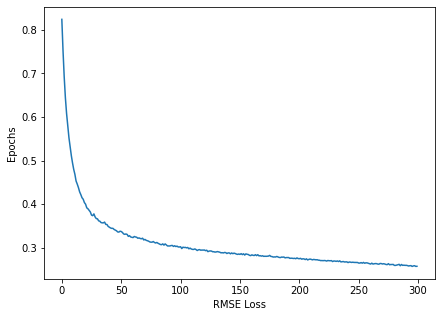

In [71]:
plt.figure(figsize = (7,5))
plt.plot(range(epochs), losses)
plt.xlabel("RMSE Loss")
plt.ylabel("Epochs")
plt.show()

In [72]:
with torch.no_grad():

    y_val = model(cat_test,con_test)
    loss = criterion(y_val, y_test)

print(f"CE Loss : {loss:.4f}")

CE Loss : 0.2522


In [73]:
rows = 50
correct = 0

print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')

for i in range(rows):

    print(f"{str(y_val[i]):26} {y_val[i].argmax():^7} {y_test[i]}")
    if y_val[i].argmax().item() == y_test[i]:
        correct+=1

print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct')

MODEL OUTPUT               ARGMAX  Y_TEST
tensor([ 2.6955, -1.6020])    0    0
tensor([-2.8453,  2.2837])    1    0
tensor([ 2.7107, -1.4614])    0    0
tensor([-1.6585,  1.4421])    1    1
tensor([ 2.4732, -1.4706])    0    0
tensor([ 1.8986, -1.8760])    0    0
tensor([ 2.2964, -0.8321])    0    0
tensor([-1.9818,  1.3012])    1    1
tensor([ 3.0756, -1.1963])    0    0
tensor([-0.5374,  0.8004])    1    1
tensor([ 1.9496, -1.6190])    0    0
tensor([ 1.6155, -2.1595])    0    0
tensor([ 0.9154, -1.7422])    0    0
tensor([-1.5441,  1.2736])    1    1
tensor([ 2.6325, -1.4063])    0    0
tensor([-4.4008,  0.7648])    1    1
tensor([ 3.0288, -1.5063])    0    1
tensor([ 2.5384, -1.2540])    0    0
tensor([ 0.7619, -0.6882])    0    0
tensor([ 1.8286, -2.2456])    0    0
tensor([-1.5873,  1.4561])    1    1
tensor([-0.5382,  0.0272])    1    1
tensor([-2.3492,  1.5988])    1    1
tensor([-2.3149,  1.1873])    1    1
tensor([-7.5704,  6.9872])    1    1
tensor([ 2.2163, -1.6738])    0  

In [74]:
if len(losses) == epochs :
    torch.save(model.state_dict() , "TaxiFareClassModel.pt")
else:
    print('Model has not been trained. Consider loading a trained model instead.')

In [75]:
emb_sizes

[(24, 12), (2, 1), (7, 4)]

In [76]:
model2 = TabularModel(emb_sizes, conts.shape[1], 2, [200,100], p = 0.4)

In [77]:
model2.load_state_dict(torch.load("TaxiFareClassModel.pt"))
model2.eval()

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [78]:
def test_data(mdl):

    # INPUT NEW DATA

    #plat = float(input('What is the pickup latitude?  '))
    #plong = float(input('What is the pickup longitude? '))
    #dlat = float(input('What is the dropoff latitude?  '))
    #dlong = float(input('What is the dropoff longitude? '))
    #psngr = int(input('How many passengers? '))
    #dt = input('What is the pickup date and time?\nFormat as YYYY-MM-DD HH:MM:SS     ')

    plat = 40.5
    plong = -73.9
    dlat = 40.52
    dlong = -73.92
    psngr = 2
    dt = "2010-04-15 16:00:00"

    # PREPROCESS THE DATA
    dfx_dict = {'pickup_latitude':plat,'pickup_longitude':plong,'dropoff_latitude':dlat,
         'dropoff_longitude':dlong,'passenger_count':psngr,'EDTdate':dt}
    dfx = pd.DataFrame(dfx_dict, index=[0])
    dfx['dist_km'] = haversine_distance(dfx,'pickup_latitude', 'pickup_longitude',
                                        'dropoff_latitude', 'dropoff_longitude')
    dfx['EDTdate'] = pd.to_datetime(dfx['EDTdate'])
    
    # We can skip the .astype(category) step since our fields are small,
    # and encode them right away
    dfx['Hour'] = dfx['EDTdate'].dt.hour
    dfx['AMorPM'] = np.where(dfx['Hour']<12,0,1) 
    dfx['WeekDay'] = dfx['EDTdate'].dt.strftime("%a")
    dfx['WeekDay'] = dfx['WeekDay'].replace(['Fri','Mon','Sat','Sun','Thu','Tue','Wed'],
                                            [0,1,2,3,4,5,6]).astype('int64')
    # CREATE CAT AND CONT TENSORS
    cat_cols = ['Hour', 'AMorPM', 'WeekDay']
    cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
                 'dropoff_longitude', 'passenger_count', 'dist_km']
                 
    xcats = np.stack([dfx[col].values for col in cat_cols], 1)
    xcats = torch.tensor(xcats, dtype=torch.int64)

    xconts = np.stack([dfx[col].values for col in cont_cols], 1)
    xconts = torch.tensor(xconts, dtype=torch.float)
    
    # PASS NEW DATA THROUGH THE MODEL WITHOUT PERFORMING A BACKPROP
    with torch.no_grad():
        z = mdl(xcats, xconts).argmax().item()
    print(f'\nThe predicted fare class is ${z}')

In [79]:
test_data(model2)


The predicted fare class is $1
